## Библиотеки, параметры, константы задачи

In [2]:
from applications.poly_features_environment import PolyFeaturesEnv
import torch
import models
import numpy as np
from common import fstream as fs
PATH_BASE = "/home/amedvedev/projects/python/DenoisingCNN"
NAME_DATASET = "gcg19"
env = PolyFeaturesEnv(name_model="uvych_max_min_pred_v2", name_dataset=NAME_DATASET, path_base=PATH_BASE,
                      device_name="cuda")


torch.Size([1, 1, 800])
params 94746400


## Загрузка данных

In [3]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        shape=(8, 80, 80), feature_name="Uvych2_abs_noised.tensor", mapper=fs.read_mc_tensor
    ) \
    .set_target(
        shape=(2,), target_name="Uvych2_abs.xls", mapper=fs.read_vector_min_max
    );

print(env.train_count, env.val_count)

27 16loading progress: |██████████████████████████████████████████████----| 93.8% Complete | 


## Модели

### Новая локальная модель

In [5]:
env.set_name_model(f"uvych_max_min_pred_v{2}")

In [4]:
env.model = models.predictors.PredictRealMaxMinv2(in_channels=8).to(env.device)

In [4]:
env.model

PredictRealMaxMinv2(
  (encoder): Sequential(
    (0): Conv2d(8, 128, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): AvgPool2d(kernel_size=2, stride=1, padding=0)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(3, 3))
    (4): LeakyReLU(negative_slope=0.01)
    (5): AvgPool2d(kernel_size=2, stride=1, padding=0)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
    (8): LeakyReLU(negative_slope=0.01)
    (9): AvgPool2d(kernel_size=2, stride=1, padding=1)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(512, 1024, kernel_size=(2, 2), stride=(2, 2))
    (12): LeakyReLU(negative_slope=0.01)
    (13): AvgPool2d(kernel_size=2, stride=1, padding=1)
    (14): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(1024, 2048, kernel_siz

### Импорт претренерованной модели

In [17]:
env.load_model(model_type="pt")

## Численные значения отклонений

In [5]:
def test():
    losses = []
    errors = []
    diff_mean = []
    with torch.no_grad():
    
        for row in zip(*env.val_features_loaders + [env.val_target_loader]):
            data_features = list(row)
            data_target = data_features.pop()
            outputs = env.model(*data_features) #* 65.
            
            
            for ex_id in range(env.val_batch_size):
                
                # mean_example = (sum(data_features[0][ex_id]) / 64).detach().numpy()
                # diff_mean.append(torch.mean(torch.abs(data_target[ex_id] - np.array([torch.min(mean_example), torch.max(mean_example)]))).detach().tolist())
                # print(diff_mean[-1])

                
                loss = torch.mean(torch.abs(outputs[ex_id] - data_target[ex_id]))
                losses.append(loss.detach().tolist())
                # print(data_target[ex_id].size())
                
                
                error = torch.mean(torch.abs(outputs[ex_id] - data_target[ex_id]) / data_target[ex_id])
                errors.append(error.detach().tolist())
                #print(outputs, data_target)
                
    print("Текущее среднее отклонение по значениям:", sum(losses) / len(losses))
    print()
    # print("Текущее среднее отклонение из усреднения:", sum(diff_mean) / len(diff_mean))
    # print()
    print("Текущее максимальное отклонение по значениям в векторе:", max(losses))
    print()
    print("Текущая средняя относительная ошибка:", sum(errors) / len(errors))
    print()
    print("Текущая максимальная относительная ошибка:", max(errors))
test()

Текущее среднее отклонение по значениям: 2.605438709259033

Текущее максимальное отклонение по значениям в векторе: 6.439251899719238

Текущая средняя относительная ошибка: 1.0078952256590128

Текущая максимальная относительная ошибка: 1.057204008102417


## Training

In [9]:
from common.losses import MseCoeffLoss, L1CoeffLoss

In [6]:
opt = torch.optim.Adam(env.model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=4)


In [7]:
env.train(30, step_saving=False, step_plotting=False,
          optimizer=opt, scheduler=None, 
          criterion=torch.nn.SmoothL1Loss(reduce="none", reduction="none"), callbacks=[lambda: scheduler.step(env.test_losses[-1])])


/home/amedvedev/projects/python/DenoisingCNN/venv/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 0.280594 	Validating Loss: 0.244738 	Time: 0.08 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 0.102736 	Validating Loss: 0.215557 	Time: 0.08 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 0.122166 	Validating Loss: 0.274078 	Time: 0.08 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 4 	Training Loss: 0.1

## Сохранение модели

In [22]:
env.save(onnx=False, pth=False)

## Loss visualisation

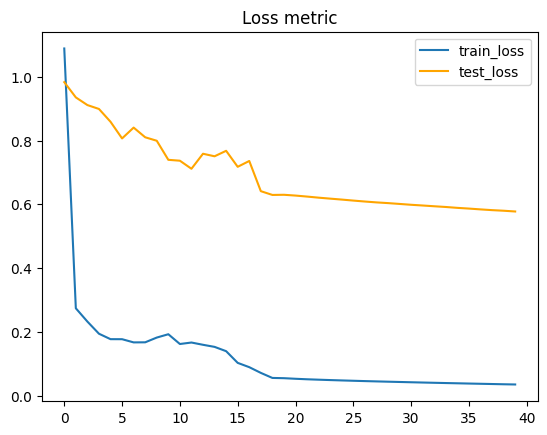

In [9]:
env.show_metrics(n_last=50, train=True, val=True)

## Clear memory

In [11]:
import gc
gc.collect()


788

In [15]:
env.model.cpu()
del env.model

torch.cuda.empty_cache()